In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn. decomposition import PCA
import joblib
import os

np.random.seed(42)
sns.set_style('whitegrid')

In [7]:
# Load dataset
df = pd.read_csv('../data/dataset.csv')

print("Dataset Shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (100000, 8)

Column names:
['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']

First 5 rows:
   distance_from_home  distance_from_last_transaction  \
0           94.689486                        0.212096   
1            2.148094                        3.631258   
2            8.201513                        0.196793   
3            1.813192                        0.613588   
4           26.211924                        4.871637   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        2.379196              1.0        0.0   
1                        0.867552              1.0        1.0   
2                        0.568646              1.0        0.0   
3                        0.749469              0.0        1.0   
4                        1.610984              1.0        0.0   

   used_pin_number  online_order  fraud  


In [8]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass Distribution:")
print(df['fraud'].value_counts())
print("\nPercentage:")
print(df['fraud'].value_counts(normalize=True) * 100)

# Remove duplicates
df = df.drop_duplicates()
print(f"\nRows after removing duplicates: {len(df)}")

Missing Values:
distance_from_home                3
distance_from_last_transaction    2
ratio_to_median_purchase_price    3
repeat_retailer                   3
used_chip                         2
used_pin_number                   3
online_order                      5
fraud                             0
dtype: int64

Class Distribution:
fraud
0    91260
1     8740
Name: count, dtype: int64

Percentage:
fraud
0    91.26
1     8.74
Name: proportion, dtype: float64

Rows after removing duplicates: 100000


In [9]:
# Separate X and y
X = df.drop('fraud', axis=1)
y = df['fraud']

print(f"Number of features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

Number of features: 7
Feature names: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']


In [10]:
# Use Random Forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X, y)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(importance_df)

# Select top 4 features
selected_features = importance_df.head(4)['Feature'].tolist()
print(f"\n✓ Selected 4 features: {selected_features}")

Feature Importance Ranking:
                          Feature  Importance
0              distance_from_home         NaN
1  distance_from_last_transaction         NaN
2  ratio_to_median_purchase_price         NaN
3                 repeat_retailer         NaN
4                       used_chip         NaN
5                 used_pin_number         NaN
6                    online_order         NaN

✓ Selected 4 features: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer']


In [11]:
# Keep only selected 4 features
X_reduced = X[selected_features].copy()

print(f"Original features: {X.shape[1]}")
print(f"Reduced features: {X_reduced.shape[1]}")
print(f"\nReduced dataset shape: {X_reduced.shape}")

Original features: 7
Reduced features: 4

Reduced dataset shape: (100000, 4)


In [12]:
# Use MinMaxScaler to scale to [0, 1] - better for quantum encoding
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_reduced)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)

print("Data normalized to [0, 1] range")
print("\nScaled data statistics:")
print(X_scaled.describe())

Data normalized to [0, 1] range

Scaled data statistics:
       distance_from_home  distance_from_last_transaction  \
count        99997.000000                    99998.000000   
mean             0.004582                        0.001009   
std              0.011151                        0.005623   
min              0.000000                        0.000000   
25%              0.000662                        0.000059   
50%              0.001708                        0.000200   
75%              0.004437                        0.000674   
max              1.000000                        1.000000   

       ratio_to_median_purchase_price  repeat_retailer  
count                    99997.000000     99997.000000  
mean                         0.014512         0.880566  
std                          0.022598         0.324300  
min                          0.000000         0.000000  
25%                          0.003711         1.000000  
50%                          0.007887         1.000

In [13]:
# Split data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set:  {X_train.shape}")
print(f"Test set:  {X_test.shape}")
print(f"\nTraining class distribution:")
print(f"  Non-Fraud: {sum(y_train == 0)}")
print(f"  Fraud: {sum(y_train == 1)}")

Training set:  (80000, 4)
Test set:  (20000, 4)

Training class distribution:
  Non-Fraud: 73008
  Fraud: 6992


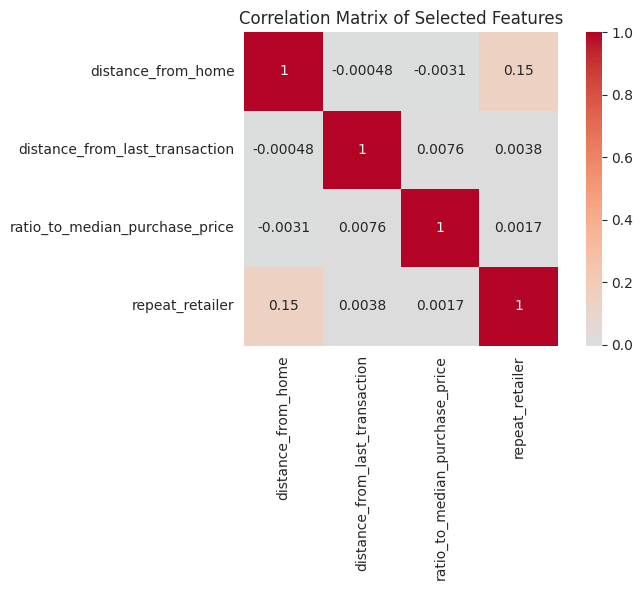

In [14]:
# Plot correlation of selected features
plt.figure(figsize=(8, 6))
correlation = X_scaled.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()

os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Create processed data directory
os.makedirs('../data/processed', exist_ok=True)

# Save train-test splits
X_train.to_csv('../data/processed/X_train_selected.csv', index=False)
X_test.to_csv('../data/processed/X_test_selected.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=['fraud'])
y_test.to_csv('../data/processed/y_test.csv', index=False, header=['fraud'])

# Save selected features and scaler
joblib.dump(selected_features, '../data/processed/selected_features.pkl')
joblib.dump(scaler, '../data/processed/scaler.pkl')

print("✓ Data saved successfully!")
print("\nSaved files:")
print("  - X_train_selected.csv")
print("  - X_test_selected.csv")
print("  - y_train.csv")
print("  - y_test.csv")
print("  - selected_features.pkl")
print("  - scaler.pkl")

✓ Data saved successfully!

Saved files:
  - X_train_selected.csv
  - X_test_selected.csv
  - y_train.csv
  - y_test.csv
  - selected_features.pkl
  - scaler.pkl


In [16]:
# Print summary
print("="*60)
print("DATA PREPROCESSING COMPLETE")
print("="*60)
print(f"Original features:  8")
print(f"Selected features: 4")
print(f"Feature names: {selected_features}")
print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nData normalized:  [0, 1] range")
print(f"Ready for Quantum and Classical models!")
print("="*60)

DATA PREPROCESSING COMPLETE
Original features:  8
Selected features: 4
Feature names: ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer']

Training samples: 80000
Test samples: 20000

Data normalized:  [0, 1] range
Ready for Quantum and Classical models!
